# Optimetrics setup

This example shows how to use PyAEDT to create a project in HFSS and create all optimetrics
setups.

Keywords: **AEDT**, **General**, **optimetrics**.

## Perform imports and define constants
Import the required packages.

In [1]:
import os
import tempfile
import time

In [2]:
import ansys.aedt.core

Define constants.

In [3]:
AEDT_VERSION = "2024.2"
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Initialize HFSS and create variables

Initialize the ``Hfss`` object and create two needed design variables,
``w1`` and ``w2``.

In [5]:
project_name = os.path.join(temp_folder.name, "optimetrics.aedt")

hfss = ansys.aedt.core.Hfss(
    project=project_name,
    version=AEDT_VERSION,
    new_desktop=True,
    non_graphical=NG_MODE,
    solution_type="Modal",
)

hfss["w1"] = "1mm"
hfss["w2"] = "100mm"

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyAEDT INFO: PyAEDT version 0.12.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_7892a72e-db5c-4ac5-aa43-27b7ce074920.log is enabled.


PyAEDT INFO: Log on AEDT is enabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 53007


PyAEDT INFO: AEDT installation Path C:\Program Files\AnsysEM\v242\Win64


PyAEDT INFO: Ansoft.ElectronicsDesktop.2024.2 version started with process ID 6464.


PyAEDT INFO: Project optimetrics has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'HFSS_813' of type HFSS.


PyAEDT INFO: Aedt Objects correctly read


## Create waveguide with sheets on it

Create one of the standard waveguide structures and parametrize it.
You can also create rectangles of waveguide openings and assign ports later.

PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Parsing design objects. This operation can take time


PyAEDT INFO: Parsing C:/Users/ansys/AppData/Local/Temp/tmpy94gr9ml.ansys/optimetrics.aedt.


PyAEDT INFO: File C:/Users/ansys/AppData/Local/Temp/tmpy94gr9ml.ansys/optimetrics.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.015624523162841797


PyAEDT INFO: 3D Modeler objects parsed. Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


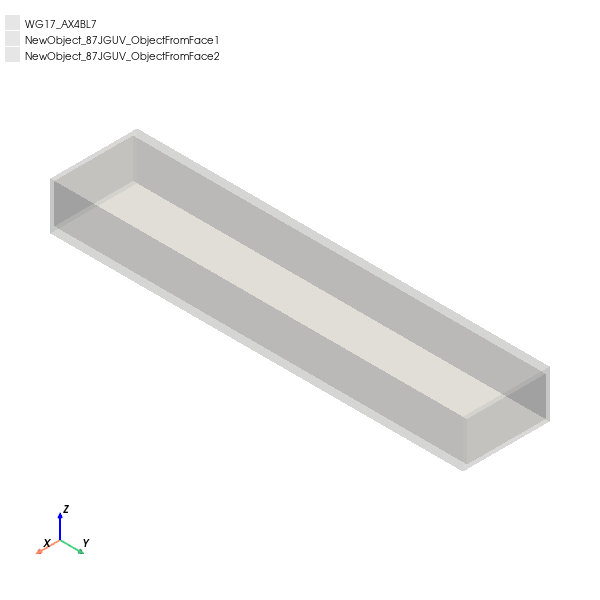

True

In [6]:
wg1, p1, p2 = hfss.modeler.create_waveguide(
    [0, 0, 0],
    hfss.AXIS.Y,
    "WG17",
    wg_thickness="w1",
    wg_length="w2",
    create_sheets_on_openings=True,
)

model = hfss.plot(show=False)

model.show_grid = False
model.plot(os.path.join(hfss.working_directory, "Image.jpg"))

## Create wave ports on sheets

Create two wave ports on the sheets.

In [7]:
hfss.wave_port(p1, integration_line=hfss.AxisDir.ZPos, name="1")
hfss.wave_port(p2, integration_line=hfss.AxisDir.ZPos, name="2")

PyAEDT INFO: Boundary Wave Port 1 has been correctly created.


PyAEDT INFO: Boundary Wave Port 2 has been correctly created.


## Create setup and frequency sweep

Create a setup and a frequency sweep to use as the base for optimetrics
setups.

In [8]:
setup = hfss.create_setup()
hfss.create_linear_step_sweep(
    setup=setup.name,
    unit="GHz",
    start_frequency=1,
    stop_frequency=5,
    step_size=0.1,
    name="Sweep1",
    save_fields=True,
)

PyAEDT INFO: Linear step sweep Sweep1 has been correctly created


## Create optimetrics analyses

### Create parametric analysis

Create a simple optimetrics parametrics analysis with output calculations.

In [9]:
sweep = hfss.parametrics.add("w2", 90, 200, 5)
sweep.add_variation("w1", 0.1, 2, 10)
sweep.add_calculation(calculation="dB(S(1,1))", ranges={"Freq": "2.5GHz"})
sweep.add_calculation(calculation="dB(S(1,1))", ranges={"Freq": "2.6GHz"})

True

### Create sensitivity analysis

Create an optimetrics sensitivity analysis with output calculations.

In [10]:
sweep2 = hfss.optimizations.add(
    calculation="dB(S(1,1))", ranges={"Freq": "2.5GHz"}, optimization_type="Sensitivity"
)
sweep2.add_variation("w1", 0.1, 3, 0.5)
sweep2.add_calculation(calculation="dB(S(1,1))", ranges={"Freq": "2.6GHz"})

True

### Create an optimization analysis

Create an optimization analysis based on goals and calculations.

In [11]:
sweep3 = hfss.optimizations.add(calculation="dB(S(1,1))", ranges={"Freq": "2.5GHz"})
sweep3.add_variation("w1", 0.1, 3, 0.5)
sweep3.add_goal(calculation="dB(S(1,1))", ranges={"Freq": "2.6GHz"})
sweep3.add_goal(calculation="dB(S(1,1))", ranges={"Freq": ("2.6GHz", "5GHz")})
sweep3.add_goal(
    calculation="dB(S(1,1))",
    ranges={"Freq": ("2.6GHz", "5GHz")},
    condition="Maximize",
)

True

### Create a DesignXplorer optimization

Create a DesignXplorer optimization based on a goal and a calculation.

In [12]:
sweep4 = hfss.optimizations.add(
    calculation="dB(S(1,1))",
    ranges={"Freq": "2.5GHz"},
    optimization_type="DesignExplorer",
)
sweep4.add_goal(calculation="dB(S(1,1))", ranges={"Freq": "2.6GHz"})

True

### Create a Design of Experiments (DOE)

Create a DOE based on a goal and a calculation.

In [13]:
sweep5 = hfss.optimizations.add(
    calculation="dB(S(1,1))", ranges={"Freq": "2.5GHz"}, optimization_type="DXDOE"
)

### Create another DOE

Create another DOE based on a goal and a calculation.

In [14]:
region = hfss.modeler.create_region()
hfss.assign_radiation_boundary_to_objects(region)
hfss.insert_infinite_sphere(name="Infinite_1")
sweep6 = hfss.optimizations.add(
    calculation="RealizedGainTotal",
    solution=hfss.nominal_adaptive,
    ranges={"Freq": "5GHz", "Theta": ["0deg", "10deg", "20deg"], "Phi": "0deg"},
    context="Infinite_1",
)

PyAEDT INFO: Boundary Radiation Rad__S4EKYU has been correctly created.


## Release AEDT

In [15]:
hfss.save_project()
hfss.release_desktop()
time.sleep(3)  # Allow AEDT to shut down before cleaning the temporary project folder.

PyAEDT INFO: Project optimetrics Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes
all temporary files, including the project folder.

In [16]:
temp_folder.cleanup()